<a href="https://colab.research.google.com/github/Achuna/Climate-Data-UMBC-Summer-Research/blob/master/Notebooks/Learning_Bayesian_Networks_from_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Previous notebooks showed how Bayesian networks economically encode a probability distribution over a set of variables, and how they can be used e.g. to predict variable states, or to generate new samples from the joint distribution. This section will be about **obtaining a Bayesian network, given a set of sample data**. Learning a Bayesian network can be split into two problems:

 **Parameter learning:** Given a set of data samples and a DAG that captures the dependencies between the variables, estimate the (conditional) probability distributions of the individual variables.
 
 **Structure learning:** Given a set of data samples, estimate a DAG that captures the dependencies between the variables.
 
This notebook aims to illustrate how parameter learning and structure learning can be done with pgmpy.
Currently, the library supports:
 - Parameter learning for *discrete* nodes:
   - Maximum Likelihood Estimation
   - Bayesian Estimation
 - Structure learning for *discrete*, *fully observed* networks:
   - Score-based structure estimation (BIC/BDeu/K2 score; exhaustive search, hill climb/tabu search)
   - Constraint-based structure estimation (PC)
   - Hybrid structure estimation (MMHC)

In [0]:
!pip install pgmpy #installing pgmpy library
!pip install CausalInference

     |████████████████████████████████| 61kB 2.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/31/3b/84/6b475799114c4c8cbaa401aff4e9fe088fc12acf55c83c1d2a
Successfully built CausalInference


# Parameter Learning

Parameter learning is the task to **estimate the values of the conditional probability distributions (CPDs), for the variables** `fruit`, `size`, and `tasty`. 


---

In [0]:
import pandas as pd

data = pd.DataFrame(data={'fruit': ["banana", "apple", "banana", "apple", "banana","apple", "banana", 
                                    "apple", "apple", "apple", "banana", "banana", "apple", "banana",], 
                          'tasty': ["yes", "no", "yes", "yes", "yes", "yes", "yes", 
                                    "yes", "yes", "yes", "yes", "no", "no", "no"], 
                          'size': ["large", "large", "large", "small", "large", "large", "large",
                                    "small", "large", "large", "large", "large", "small", "small"]})
data

,fruit,tasty,size
0,banana,yes,large
1,apple,no,large
2,banana,yes,large
3,apple,yes,small
4,banana,yes,large
5,apple,yes,large
6,banana,yes,large
7,apple,yes,small
8,apple,yes,large
9,apple,yes,large


##Maximum Likelihood Estimation

A natural estimate for the CPDs is to simply use the **relative frequencies**, with which the variable states have occured. We observed `7 apples` among a total of `14 fruits`, so we might guess that about `50%` of `fruits` are `apples`.

This approach is *Maximum Likelihood Estimation (MLE)*. According to MLE, we should fill the CPDs in such a way, that $P(\text{data}|\text{model})$ is maximal. This is achieved when using the *relative frequencies*.

In [0]:
from pgmpy.models import BayesianModel

#Define the model structure

model = BayesianModel([('fruit', 'tasty'), ('size', 'tasty')])

model.edges()

[('fruit', 'tasty'), ('size', 'tasty')]

In [0]:
!pip install graphviz #Use to visualize network

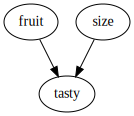

In [0]:
from graphviz import Digraph #directed graph (good for bayesian networks)

edges = model.edges() #store connections in a variable

g = Digraph('Fruit_Graph', filename='fruits') #name, filename

#Create connections given the edges 
for i in range(0, len(edges)):
  parent = edges[i][0]
  child = edges[i][1]
  g.edge(parent, child)
    
g

**State counts**

To make sense of the given data, we can start by counting how often each state of the variable occurs. If the variable is dependent on parents, the counts are done conditionally on the parents states, i.e. for seperately for each parent configuration:

In [0]:
from pgmpy.estimators import ParameterEstimator #import parameterEstimator

pe = ParameterEstimator(model, data)

#counting how often each state of the variable occurs.

#Fruit has 2 states (apple, banana) - 7 apples, 7 bananas
print("\n", pe.state_counts('fruit'))  # unconditional (not subject to any conditions)

#Tasty has 2 states (yes, no)
print("\n", pe.state_counts('tasty'))  # conditional on fruit and size


         fruit
apple       7
banana      7

 fruit apple       banana      
size  large small  large small
tasty                         
no      1.0   1.0    1.0   1.0
yes     3.0   2.0    5.0   0.0


In [0]:
from pgmpy.estimators import MaximumLikelihoodEstimator #import MLE library


mle = MaximumLikelihoodEstimator(model, data) #input the BN model and dataframe

#Estimate the CPDs using the relative frequencies of each state counts

print(mle.estimate_cpd('fruit'))  # unconditional)
#print(mle.estimate_cpd('size')) #unconditional 
print(mle.estimate_cpd('tasty'))  # conditional

+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+
+------------+--------------+--------------------+---------------------+---------------+
| fruit      | fruit(apple) | fruit(apple)       | fruit(banana)       | fruit(banana) |
+------------+--------------+--------------------+---------------------+---------------+
| size       | size(large)  | size(small)        | size(large)         | size(small)   |
+------------+--------------+--------------------+---------------------+---------------+
| tasty(no)  | 0.25         | 0.3333333333333333 | 0.16666666666666666 | 1.0           |
+------------+--------------+--------------------+---------------------+---------------+
| tasty(yes) | 0.75         | 0.6666666666666666 | 0.8333333333333334  | 0.0           |
+------------+--------------+--------------------+---------------------+---------------+


`mle.estimate_cpd(variable)` computes the **state counts and divides each cell by the (conditional) sample size**. The `mle.get_parameters()`-method returns a list of CPDs for all variable of the model.

The built-in `fit()`-method of `BayesianModel` provides more convenient access to parameter estimators:

In [0]:
# Calibrate all CPDs of `model` using MLE:

model.fit(data, estimator=MaximumLikelihoodEstimator) #adding CPDs to each node using MLE 

#print(model.get_cpds('tasty'))

+------------+--------------+--------------------+---------------------+---------------+
| fruit      | fruit(apple) | fruit(apple)       | fruit(banana)       | fruit(banana) |
+------------+--------------+--------------------+---------------------+---------------+
| size       | size(large)  | size(small)        | size(large)         | size(small)   |
+------------+--------------+--------------------+---------------------+---------------+
| tasty(no)  | 0.25         | 0.3333333333333333 | 0.16666666666666666 | 1.0           |
+------------+--------------+--------------------+---------------------+---------------+
| tasty(yes) | 0.75         | 0.6666666666666666 | 0.8333333333333334  | 0.0           |
+------------+--------------+--------------------+---------------------+---------------+


While very straightforward, the **ML estimator has the problem of overfitting to the data**. In above CPD, the probability of a large banana being tasty is estimated at `0.833`, because `5` out of `6` observed large bananas were tasty. Fine. But note that the probability of a small banana being tasty is estimated at `0.0`, because we  observed only one small banana and it happened to be not tasty. But that should hardly make us certain that small bananas aren't tasty!
**We simply do not have enough observations to rely on the observed frequencies**. If the observed data is not representative for the underlying distribution, ML estimations will be extremly far off. 

**When estimating parameters for Bayesian networks, lack of data is a frequent problem.** Even if the total sample size is very large, the fact that state counts are done conditionally for each parents configuration causes immense fragmentation. If a variable has 3 parents that can each take 10 states, then state counts will be done seperately for `10^3 = 1000` parents configurations. **This makes MLE very fragile and unstable for learning Bayesian Network parameters**. A way to mitigate MLE's overfitting is *Bayesian Parameter Estimation*.

## Bayesian Parameter Estimation

The Bayesian Parameter Estimator starts with already existing prior CPDs, that express our beliefs about the variables *before* the data was observed. Those "priors" are then updated, using the state counts from the observed data. See [1], Section 17.3 for a general introduction to Bayesian estimators.

One can think of the priors as consisting in *pseudo state counts*, that are added to the actual counts before normalization.
Unless one wants to encode specific beliefs about the distributions of the variables, one commonly chooses uniform priors, i.e. ones that deem all states equiprobable.

A very simple prior is the so-called **K2 prior, which simply adds `1` to the count of every single state.**
A somewhat more sensible choice of prior is *BDeu* (Bayesian Dirichlet equivalent uniform prior). For **BDeu we need to specify an equivalent sample size `N` and then the pseudo-counts are the equivalent of having observed `N` uniform samples of each variable (and each parent configuration)**. In pgmpy:

In [0]:
from pgmpy.estimators import BayesianEstimator

est = BayesianEstimator(model, data)

#variable, prior CPD calculation type, sample size
print(est.estimate_cpd('tasty', prior_type='BDeu', equivalent_sample_size=10))

+------------+---------------------+--------------------+--------------------+---------------------+
| fruit      | fruit(apple)        | fruit(apple)       | fruit(banana)      | fruit(banana)       |
+------------+---------------------+--------------------+--------------------+---------------------+
| size       | size(large)         | size(small)        | size(large)        | size(small)         |
+------------+---------------------+--------------------+--------------------+---------------------+
| tasty(no)  | 0.34615384615384615 | 0.4090909090909091 | 0.2647058823529412 | 0.6428571428571429  |
+------------+---------------------+--------------------+--------------------+---------------------+
| tasty(yes) | 0.6538461538461539  | 0.5909090909090909 | 0.7352941176470589 | 0.35714285714285715 |
+------------+---------------------+--------------------+--------------------+---------------------+


The estimated values in the CPDs are now more conservative. In particular, the estimate for a small banana being not tasty is now around `0.64` rather than `1.0`. Setting `equivalent_sample_size` to `10` means that for each parent configuration, we add the equivalent of 10 uniform samples (here: `+5` small bananas that are tasty and `+5` that aren't).

`BayesianEstimator`, too, can be used via the `fit()`-method. Full example:

In [0]:
model.fit(data, estimator=BayesianEstimator, prior_type="BDeu") # default equivalent_sample_size=5

for cpd in model.get_cpds():
  print(cpd)

+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+
+-------------+----------+
| size(large) | 0.657895 |
+-------------+----------+
| size(small) | 0.342105 |
+-------------+----------+
+------------+---------------------+---------------------+---------------------+--------------------+
| fruit      | fruit(apple)        | fruit(apple)        | fruit(banana)       | fruit(banana)      |
+------------+---------------------+---------------------+---------------------+--------------------+
| size       | size(large)         | size(small)         | size(large)         | size(small)        |
+------------+---------------------+---------------------+---------------------+--------------------+
| tasty(no)  | 0.30952380952380953 | 0.38235294117647056 | 0.22413793103448276 | 0.7222222222222222 |
+------------+---------------------+---------------------+---------------------+--------------------+
| tasty(yes) | 0.69047619047619

# Structure Learning

To learn model structure (a DAG) from a data set, there are two broad techniques:

 - **score-based structure learning**
 - **constraint-based structure learning**

The combination of both techniques allows further improvement:
 - hybrid structure learning

We briefly discuss all approaches and give examples.

## Score-based Structure Learning


This approach construes model selection as an optimization task. It has two building blocks:

- A _scoring function_ $s_D\colon M \to \mathbb R$ that maps models to a numerical score, based on how well they fit to a given data set $D$.
- A _search strategy_ to traverse the search space of possible models $M$ and select a model with optimal score.


**Scoring functions**

Commonly used scores to measure the fit between model and data are _Bayesian Dirichlet scores_ such as *BDeu* or *K2* and the _Bayesian Information Criterion_ (BIC, also called MDL).

In [0]:
import pandas as pd
import numpy as np 

from pgmpy.estimators import BdeuScore, K2Score, BicScore #import scoring functions
from pgmpy.models import BayesianModel

# create random data sample with 3 variables, where Z is dependent on X, Y:
data = pd.DataFrame(np.random.randint(0, 4, size=(5000, 2)), columns=list('XY'))

data['Z'] = data['X'] + data['Y'] #Z is the sum of X and Y and is conditional

#print(data)

bdeu = BdeuScore(data, equivalent_sample_size=5)
k2 = K2Score(data)
bic = BicScore(data)

model1 = BayesianModel([('X', 'Z'), ('Y', 'Z')])  # X -> Z <- Y
model2 = BayesianModel([('X', 'Z'), ('X', 'Y')])  # Y <- X -> Z

print("Model 1 Scores:")
print(bdeu.score(model1))
print(k2.score(model1))
print(bic.score(model1))

print("\nModel 2 Scores:")
print(bdeu.score(model2))
print(k2.score(model2))
print(bic.score(model2))

Model 1 Scores:
-13938.083889714904
-14328.819537651345
-14294.126211903193

Model 2 Scores:
-20895.407800410983
-20922.258556054487
-20939.458761183072


While the scores vary slightly, we can see that the correct `model1` has a much higher score than `model2`.
Importantly, these scores _decompose_, i.e. they can be computed locally for each of the variables given their potential parents, independent of other parts of the network:

In [0]:
#getting local scores of node placement provided the parents of the child node
print(bdeu.local_score('Z', parents=[]))
print(bdeu.local_score('Z', parents=['X']))
print(bdeu.local_score('Z', parents=['X', 'Y']))

-9207.07941207628
-6991.523722830527
-57.119868733414705


**Search strategies**


---


The search space of DAGs is super-exponential in the number of variables and the above scoring functions allow for local maxima. The first property makes exhaustive search intractable for all but very small networks, the second prohibits efficient local optimization algorithms to always find the optimal structure. Thus, identifiying the ideal structure is often not tractable. Despite these bad news, heuristic search strategies often yields good results.

If only few nodes are involved (read: less than 5), `ExhaustiveSearch` can be used to compute the score for every DAG and returns the best-scoring one:

In [0]:
from pgmpy.estimators import ExhaustiveSearch

#Exhaust all possible networks and rate them according to the scoring method
es = ExhaustiveSearch(data, scoring_method=bdeu)

best_model = es.estimate() #returns the model with highest score
print("best model: ")
print(best_model.edges())

print("\nAll DAGs by score:")
for score, dag in es.all_scores(): #es.all_score() returns tuple (score, DAG)
    print(score, dag.edges())

best model: 
[('X', 'Z'), ('Y', 'Z')]

All DAGs by score:
-23117.68561978954 [('Y', 'X')]
-23117.685619789532 [('X', 'Y')]
-23088.58382564038 []
-20902.309885737523 [('Y', 'Z'), ('Y', 'X')]
-20902.309885737523 [('Y', 'X'), ('Z', 'Y')]
-20902.30988573752 [('X', 'Y'), ('Y', 'Z')]
-20902.129930543786 [('X', 'Z'), ('Y', 'X')]
-20902.12993054378 [('X', 'Y'), ('X', 'Z')]
-20902.12993054378 [('X', 'Y'), ('Z', 'X')]
-20873.208091588363 [('Y', 'Z')]
-20873.208091588363 [('Z', 'Y')]
-20873.028136394627 [('X', 'Z')]
-20873.028136394627 [('Z', 'X')]
-18657.65240234261 [('X', 'Z'), ('Z', 'Y')]
-18657.65240234261 [('Y', 'Z'), ('Z', 'X')]
-18657.65240234261 [('Z', 'X'), ('Z', 'Y')]
-16183.281765692424 [('X', 'Y'), ('Z', 'Y')]
-16183.101810498685 [('Y', 'X'), ('Z', 'X')]
-13967.726076446672 [('X', 'Z'), ('Y', 'Z'), ('Y', 'X')]
-13967.72607644667 [('X', 'Y'), ('X', 'Z'), ('Z', 'Y')]
-13967.72607644667 [('X', 'Y'), ('Z', 'X'), ('Z', 'Y')]
-13967.72607644667 [('Y', 'Z'), ('Y', 'X'), ('Z', 'X')]
-13967.72

Once more nodes are involved, one needs to switch to heuristic search. **'HillClimbSearch'** implements a greedy local search that starts from the DAG `start` (default: disconnected DAG) and proceeds by iteratively performing single-edge manipulations that maximally increase the score. The search terminates once a local maximum is foun

In [0]:
from pgmpy.estimators import HillClimbSearch

# create some data with dependencies
data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 6)), columns=list('ABCDEF'))
data['G'] = data['A'] + data['B'] #G depends on A and B
data['H'] = data['E'] + data['F'] 

#single edge manipulations to increase score
hc = HillClimbSearch(data, scoring_method=BicScore(data)) 

#bstart = BayesianModel([('A', 'G'), ('B', 'G')])

best_model = hc.estimate()
print(best_model.edges())

[('A', 'G'), ('B', 'G'), ('E', 'H'), ('F', 'H')]


To enforce a wider exploration of the search space, the search can be enhanced with a tabu list. The list keeps track of the last `n` modfications; those are then not allowed to be reversed, regardless of the score. Additionally a `white_list` or `black_list` can be supplied to restrict the search to a particular subset or to exclude certain edges. The parameter `max_indegree` allows to restrict the maximum number of parents for each node.

## Constraint-Based Structure Learning

A different, but quite straightforward approach to build a DAG from data is this:

1. Identify independencies in the data set using hypothesis tests 
2. Construct DAG (pattern) according to identified independencies

#### (Conditional) Independence Tests

Independencies in the data can be identified using chi2 conditional independence tests. To this end, constraint-based estimators in pgmpy have a `test_conditional_independence(X, Y, Zs)`-method, that performs a hypothesis test on the data sample. It allows to check if `X` is independent from `Y` given a set of variables `Zs`:



In [0]:
from pgmpy.estimators import ConstraintBasedEstimator
import pandas as pd
import numpy as np

data = pd.DataFrame(np.random.randint(3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']
data['E'] *= data['F']

      
print(type(data)  )    
est = ConstraintBasedEstimator(data)
print(est.test_conditional_independence('B', 'H'))          # dependent
# print(est.test_conditional_independence('B', 'E'))          # independent
# print(est.test_conditional_independence('B', 'H', ['A']))   # independent
# print(est.test_conditional_independence('A', 'G'))          # independent
# print(est.test_conditional_independence('A', 'G',  ['H']))  # dependent

<class 'pandas.core.frame.DataFrame'>
(643.4022904448409, 5.158434875085489e-119, True)


`test_conditional_independence()` returns a tripel `(chi2, p_value, sufficient_data)`, consisting in the computed chi2 test statistic, the `p_value` of the test, and a heuristig flag that indicates if the sample size was sufficient. The `p_value` is the probability of observing the computed chi2 statistic (or an even higher chi2 value), given the null hypothesis that X and Y are independent given Zs.

This can be used to make independence judgements, at a given level of significance:



---

high significance (p-value) = independence

low significance (p-value) = dependence

high chi2 = weak relationship

low chi2 = strong relationship


**Vocabulary**

Chi2 (chi squared) - A low value for chi-square means there is a high correlation between your two sets of data and vice versa. The larger the Chi-square value, the greater the probability that there really is a significant difference.  


---

p value - A value between 0 and 1 used to show the significance level (significance of correlation). (P-value<=0.05: strong evidence against the null hypothesis vice versa) When the data is perfectly described by the resticted model, the probability to get data that is less well described is 1

---



In [0]:
def is_independent(X, Y, Zs=[], significance_level=0.05):
    return est.test_conditional_independence(X, Y, Zs)[1] >= significance_level

print(is_independent('B', 'H'))
print(is_independent('B', 'E'))
print(is_independent('B', 'H', ['A']))
print(is_independent('A', 'G'))
print(is_independent('A', 'G', ['H']))

False
True
True
True
False


**DAG (pattern) construction**

With a method for independence testing at hand, we can construct a DAG from the data set in three steps:
1. Construct an undirected skeleton - `estimate_skeleton()`
2. Orient compelled edges to obtain partially directed acyclid graph (PDAG; I-equivalence class of DAGs) - `skeleton_to_pdag()`
3. Extend DAG pattern to a DAG by conservatively orienting the remaining edges in some way - `pdag_to_dag()`

Step 1.&2. form the so-called PC algorithm, see [2], page 550. PDAGs are `DirectedGraph`s, that may contain both-way edges, to indicate that the orientation for the edge is not determined.

In [0]:
skel, seperating_sets = est.estimate_skeleton(significance_level=0.01)
print("Undirected edges: ", skel.edges())

pdag = est.skeleton_to_pdag(skel, seperating_sets)
print("PDAG edges:       ", pdag.edges())

model = est.pdag_to_dag(pdag)
print("DAG edges:        ", model.edges())

#short-hand of the methods above in order to get to creating the DAG
est.estimate(significance_level=0.01).edges()


# significance_level` is the desired Type 1 error probability of
# falsely rejecting the null hypothesis that variables are independent,
# given that they are. The lower `significance_level`, the less likely
# we are to accept dependencies, resulting in a sparser graph.

Undirected edges:  [('A', 'B'), ('A', 'C'), ('A', 'H'), ('E', 'F'), ('G', 'H')]
PDAG edges:        [('A', 'H'), ('B', 'A'), ('C', 'A'), ('E', 'F'), ('F', 'E'), ('G', 'H')]
DAG edges:         [('A', 'H'), ('B', 'A'), ('C', 'A'), ('F', 'E'), ('G', 'H')]


[('A', 'H'), ('B', 'A'), ('C', 'A'), ('F', 'E'), ('G', 'H')]

The `estimate_from_independencies()`-method can be used to construct a `BayesianModel` from a provided *set of independencies* (see class documentation for further features & methods):

In [0]:
from pgmpy.independencies import Independencies

ind = Independencies(['B', 'C'],
                     ['A', ['B', 'C'], 'D'])
ind = ind.closure()  # required (!) for faithfulness

model = ConstraintBasedEstimator.estimate_from_independencies("ABCD", ind)

print(model.edges())

[('A', 'D'), ('B', 'D'), ('C', 'D')]


## Hybrid Structure Learning

This Hybrid structure learning combines the constraint-based and score-based method. It has two parts:

1. Learn undirected graph skeleton using the constraint-based construction procedure MMPC
2. Orient edges using score-based optimization (BDeu score + modified hill-climbing)

We can perform the two steps seperately, more or less as follows:

In [0]:
import pandas as pd
import numpy as np
from pgmpy.estimators import ConstraintBasedEstimator, HillClimbSearch
from pgmpy.estimators import BdeuScore, K2Score, BicScore #import scoring functions
from pgmpy.models import BayesianModel

data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 7)), columns=list('ABCEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']
data['E'] *= data['F']

#Create undirected graph skeleton
constraintEstimate = ConstraintBasedEstimator(data)
start, sets = constraintEstimate.estimate_skeleton(significance_level=0.01)

bmodel = BayesianModel(start.edges())

print("Part 1) Skeleton: ", bmodel.edges())

# use hill climb search to orient the edges:
hc = HillClimbSearch(data, scoring_method=BdeuScore(data))
model = hc.estimate(start=bmodel)
print("Part 2) Model:    ", model.edges())

Part 1) Skeleton:  [('A', 'B'), ('A', 'C'), ('A', 'H'), ('E', 'F'), ('G', 'H')]
Part 2) Model:     [('A', 'B'), ('A', 'C'), ('A', 'H'), ('C', 'B'), ('E', 'F'), ('G', 'H')]


# Practice Playground

In [0]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris

iris=load_iris() #loading flower dataset

#print(iris)

columns = iris['feature_names'] #original names of colums in dataset
data = iris['data']
target = iris['target']

df = pd.DataFrame(data, columns = columns)
df.insert(len(columns), "Type", target) #combine training and target data into one dataframe
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Type
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


[('petal width (cm)', 'petal length (cm)'), ('petal width (cm)', 'sepal width (cm)'), ('Type', 'petal width (cm)'), ('Type', 'sepal length (cm)'), ('Type', 'petal length (cm)')]


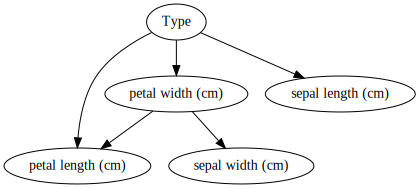

In [0]:
from pgmpy.estimators import BdeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch
from graphviz import Digraph #directed graph (good for bayesian networks)


bdeu = BdeuScore(df, equivalent_sample_size=400)

#single edge manipulations to increase score
hc = HillClimbSearch(df, scoring_method=bdeu) 

best_model = hc.estimate()
print(best_model.edges())

###Print out Bayesian Network

edges = best_model.edges() #store connections in a variable

g = Digraph('Flower', filename='fruits') #name, filename

#Create connections given the edges 
for i in range(0, len(edges)):
  parent = edges[i][0]
  child = edges[i][1]
  g.edge(parent, child)
    
g

In [0]:
from pgmpy.estimators import BayesianEstimator

#est = BayesianEstimator(model, data)

best_model.fit(df, estimator=BayesianEstimator, prior_type="BDeu") 

for cpd in best_model.get_cpds():
  print(cpd)

+------------------------+-----------------------+-----------------------+-----------------------+
| Type                   | Type(0)               | Type(1)               | Type(2)               |
+------------------------+-----------------------+-----------------------+-----------------------+
| sepal length (cm)(4.3) | 0.0202764976958525    | 0.0009216589861751143 | 0.0009216589861751146 |
+------------------------+-----------------------+-----------------------+-----------------------+
| sepal length (cm)(4.4) | 0.05898617511520727   | 0.0009216589861751143 | 0.0009216589861751146 |
+------------------------+-----------------------+-----------------------+-----------------------+
| sepal length (cm)(4.5) | 0.0202764976958525    | 0.0009216589861751143 | 0.0009216589861751146 |
+------------------------+-----------------------+-----------------------+-----------------------+
| sepal length (cm)(4.6) | 0.07834101382488465   | 0.0009216589861751143 | 0.0009216589861751146 |
+---------

In [0]:
from pgmpy.estimators import ExhaustiveSearch

#Exhaust all possible networks and rate them according to the scoring method
es = ExhaustiveSearch(df, scoring_method=bdeu)

best_model = es.estimate() #returns the model with highest score
print("best model: ")
print(best_model.edges())

print("\nAll DAGs by score:")
for score, dag in es.all_scores(): #es.all_score() returns tuple (score, DAG)
    print(score, dag.edges())

# PGMLearner Library

In [0]:
import json

from libpgm.nodedata import NodeData
from libpgm.graphskeleton import GraphSkeleton
from libpgm.lgbayesiannetwork import LGBayesianNetwork
from libpgm.discretebayesiannetwork import DiscreteBayesianNetwork
from libpgm.pgmlearner import PGMLearner



# instantiate my learner 
learner = PGMLearner()

# learn bayesian network
result = learner.lg_estimatebn(data)

# output
print json.dumps(result.E, indent=2)
print json.dumps(result.Vdata, indent=2)

# DISCRETE

# generate some data to use
nd = NodeData()
nd.load("../tests/unittestdict.txt")    # an input file
skel = GraphSkeleton()
skel.load("../tests/unittestdict.txt")
skel.toporder()
bn = DiscreteBayesianNetwork(skel, nd)
data = bn.randomsample(8000)

# instantiate my learner 
learner = PGMLearner()

# learn bayesian network
result = learner.discrete_estimatebn(data)

# output
print json.dumps(result.E, indent=2)
print json.dumps(result.Vdata, indent=2)

# Reference

https://github.com/pgmpy/pgmpy_notebook/blob/master/notebooks/9.%20Learning%20Bayesian%20Networks%20from%20Data.ipynb


---



[1] [Koller & Friedman, Probabilistic Graphical Models - Principles and Techniques, 2009](https://drive.google.com/file/d/1C1O6L_7CrFL2TPEi7Ei6RfTQd93MNRUT/view?usp=sharing)

[2] [Neapolitan, Learning Bayesian Networks, 2003](http://www.cs.technion.ac.il/~dang/books/Learning%20Bayesian%20Networks&#40;Neapolitan,%20Richard&#41;.pdf)

[3] [Tsamardinos et al., The max-min hill-climbing BN structure learning algorithm, 2005](http://www.dsl-lab.org/supplements/mmhc_paper/paper_online.pdf)


---

Others:

http://pgmpy.chrisittner.de/2016/08/17/pc.html#pc



In [0]:
from pgmpy.utils.mathext import powerset
from pgmpy.base import UndirectedGraph
from pgmpy.models import BayesianModel
from pgmpy.estimators import StructureEstimator, HillClimbSearch, BdeuScore
from pgmpy.independencies import Independencies, IndependenceAssertion


class MmhcEstimator(StructureEstimator):
    def __init__(self, data, **kwargs):
        """
        Implements the MMHC hybrid structure estimation procedure for
        learning BayesianModels from discrete data.
        Parameters
        ----------
        data: pandas DataFrame object
            datafame object where each column represents one variable.
            (If some values in the data are missing the data cells should be set to `numpy.NaN`.
            Note that pandas converts each column containing `numpy.NaN`s to dtype `float`.)
        state_names: dict (optional)
            A dict indicating, for each variable, the discrete set of states (or values)
            that the variable can take. If unspecified, the observed values in the data set
            are taken to be the only possible states.
        complete_samples_only: bool (optional, default `True`)
            Specifies how to deal with missing data, if present. If set to `True` all rows
            that contain `np.Nan` somewhere are ignored. If `False` then, for each variable,
            every row where neither the variable nor its parents are `np.NaN` is used.
            This sets the behavior of the `state_count`-method.
        Reference
        ---------
        Tsamardinos et al., The max-min hill-climbing Bayesian network structure learning algorithm (2005)
        http://www.dsl-lab.org/supplements/mmhc_paper/paper_online.pdf
        """
        super(MmhcEstimator, self).__init__(data, **kwargs)

    def estimate(self, significance_level=0.01):
        """
        Estimates a BayesianModel for the data set, using MMHC. First estimates a
        graph skeleton using MMPC and then orients the edges using score-based local
        search (hill climbing).
        Parameters
        ----------
        significance_level: float, default: 0.01
            The significance level to use for conditional independence tests in the data set. See `mmpc`-method.
        Returns
        -------
        model: BayesianModel()-instance, not yet parametrized.
        Reference
        ---------
        Tsamardinos et al., The max-min hill-climbing Bayesian network structure learning algorithm (2005),
        Algorithm 3
        http://www.dsl-lab.org/supplements/mmhc_paper/paper_online.pdf
        Examples
        --------
        >>> import pandas as pd
        >>> import numpy as np
        >>> from pgmpy.estimators import ConstraintBasedEstimator
        >>> data = pd.DataFrame(np.random.randint(0, 2, size=(2500, 4)), columns=list('XYZW'))
        >>> data['sum'] = data.sum(axis=1)
        >>> est = MmhcEstimator(data)
        >>> model = est.estimate()
        >>> print(model.edges())
        [('Z', 'sum'), ('X', 'sum'), ('W', 'sum'), ('Y', 'sum')]
        """

        skel = self.mmpc(significance_level)

        hc = HillClimbSearch(self.data, scoring_method=BdeuScore(self.data, equivalent_sample_size=10))
        model = hc.estimate(white_list=skel.to_directed().edges(), tabu_length=10)

        return model

    def mmpc(self, significance_level=0.01):
        """Estimates a graph skeleton (UndirectedGraph) for the data set, using then
        MMPC (max-min parents-and-children) algorithm.
        Parameters
        ----------
        significance_level: float, default=0.01
            The significance level to use for conditional independence tests in the data set.
            `significance_level` is the desired Type 1 error probability of
            falsely rejecting the null hypothesis that variables are independent,
            given that they are. The lower `significance_level`, the less likely
            we are to accept dependencies, resulting in a sparser graph.
        Returns
        -------
        skeleton: UndirectedGraph
            An estimate for the undirected graph skeleton of the BN underlying the data.
        seperating_sets: dict
            A dict containing for each pair of not directly connected nodes a
            seperating set ("witnessing set") of variables that makes then
            conditionally independent. (needed for edge orientation)
        Reference
        ---------
        Tsamardinos et al., The max-min hill-climbing Bayesian network structure learning algorithm (2005),
        Algorithm 1 & 2
        http://www.dsl-lab.org/supplements/mmhc_paper/paper_online.pdf
        Examples
        --------
        >>> import pandas as pd
        >>> import numpy as np
        >>> from pgmpy.estimators import ConstraintBasedEstimator
        >>>
        >>> data = pd.DataFrame(np.random.randint(0, 2, size=(5000, 5)), columns=list('ABCDE'))
        >>> data['F'] = data['A'] + data['B'] + data ['C']
        >>> est = ConstraintBasedEstimator(data)
        >>> skel, sep_sets = est.estimate_skeleton()
        >>> skel.edges()
        [('A', 'F'), ('B', 'F'), ('C', 'F')]
        >>> # all independencies are unconditional:
        >>> sep_sets
        {('D', 'A'): (), ('C', 'A'): (), ('C', 'E'): (), ('E', 'F'): (), ('B', 'D'): (),
         ('B', 'E'): (), ('D', 'F'): (), ('D', 'E'): (), ('A', 'E'): (), ('B', 'A'): (),
         ('B', 'C'): (), ('C', 'D'): ()}
        >>>
        >>> data = pd.DataFrame(np.random.randint(0, 2, size=(5000, 3)), columns=list('XYZ'))
        >>> data['X'] += data['Z']
        >>> data['Y'] += data['Z']
        >>> est = ConstraintBasedEstimator(data)
        >>> skel, sep_sets = est.estimate_skeleton()
        >>> skel.edges()
        [('X', 'Z'), ('Y', 'Z')]
        >>> # X, Y dependent, but conditionally independent given Z:
        >>> sep_sets
        {('X', 'Y'): ('Z',)}
        """

        nodes = self.state_names.keys()

        

ModuleNotFoundError: ignored